<a href="https://colab.research.google.com/github/AbdullaK123/AbdullaK123.github.io/blob/main/time_series_forecasting_with_Nbeats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, we will apply the N-beats algorithm, as detailed in this paper:

https://arxiv.org/pdf/1905.10437.pdf

to predicting Apple stock prices. We will use 16 years worth of data using the Yahoo Finance API, and our goal is to show that an N-beats model can outperform a naive forecast of the data, in which we assume that the next day's price is simply yesterday's price. In the literature, this forecast is known to be very difficult for models to outperform. And we will show how our model can out perform it, using the following metrics:

- The Mean Absolute Error

- The Mean Absolute Scaled Error

- The Root Mean Squared Error

To begin, let us import the tools that we will need for our analysis.

In [1]:
import tensorflow as tf # for creating and training our N-beats model
import yfinance as yf # for importing our data
import numpy as np # for data manipulation
import pandas as pd # for data manipulation
import plotly.express as px # for data visualization
import plotly.graph_objects as go # for data visualization
from sklearn.metrics import mean_absolute_error, mean_squared_error # for our metrics
from sklearn.preprocessing import MinMaxScaler # for scaling our data


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


Now that we've imported the tools we will need, let us import our data using the Yahoo Finance API.

# The Data


In [2]:
# Importing our data (Note that the stock ticker for Apple is AAPL, and that we are interested in collecting 10 years worth of data with a one day interval)

stock_data = yf.Ticker('AAPL').history( interval='1d', start='2008-01-31')

stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2008-01-31 00:00:00-05:00,3.919006,4.136981,3.917493,4.097928,1345674400,0.0,0.0
2008-02-01 00:00:00-05:00,4.124569,4.135165,4.001655,4.049186,1010744000,0.0,0.0
2008-02-04 00:00:00-05:00,4.063110,4.114273,3.978644,3.985608,899234000,0.0,0.0
2008-02-05 00:00:00-05:00,3.948673,4.056752,3.902353,3.916280,1141042000,0.0,0.0
2008-02-06 00:00:00-05:00,3.960785,3.993784,3.686500,3.693463,1573272400,0.0,0.0


For simplicity, let's use only the closing price for our univariate forecasting model, and then move on to some exploratory data analysis, in which we will visualize our data with a time-series plot.

In [3]:
closing_prices = stock_data[['Close']]

closing_prices.head()

,Close
Date,
2008-01-31 00:00:00-05:00,4.097928
2008-02-01 00:00:00-05:00,4.049186
2008-02-04 00:00:00-05:00,3.985608
2008-02-05 00:00:00-05:00,3.916280
2008-02-06 00:00:00-05:00,3.693463


# Exploratory Data Analysis


In [4]:
# Time series plot of the closing price with a linear trend line
fig = px.line(closing_prices, y='Close', title='<b>Closing Price of AAPL Stock</b>')

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font={
        'color':'white',
        'size':18
    },
    title = {
        'x':0.5,
        'xanchor':'center',
        'yanchor':'top',
        'font':{
            'size':24,
            'family':'Arial'
        }
    }
)

fig.update_traces(
    line = {'color':'cyan'}
)

# calculating the trendline with numpy's polyfit

X = pd.to_datetime(pd.Series(closing_prices.index)).apply(lambda date:date.toordinal())
y = closing_prices['Close']

coeffs = np.polyfit(X, y, 1)
trendline = np.polyval(coeffs, X)


# creating a dataframe for visualization purposes
viz_df = pd.DataFrame({
    'date': closing_prices.index.values,
    'trend': trendline
})

# adding the trendline to the plot
fig.add_trace(
    go.Scatter(
        x=viz_df['date'],
        y=viz_df['trend'],
        mode='lines',
        name='Trendline'
    )
)

fig.show()


From the trendline, we see that Apple's stock price has enjoyed consistent growth over the past five years. There seems to be no seasonality or patterns in the data as well, which is to be expected given the random nature of stock prices. However, let's now prepare our data for our naive forecast.

# Preparing the Data (for the Naive Forecast)

In [5]:
# defining the test split
test_split = int(0.8*len(closing_prices))

# splitting our data (80% train / 20% test)
train_data = closing_prices.iloc[:test_split]
test_data = closing_prices.iloc[test_split:]

Now that we've split our data into training and test sets, let's define the functions we are going to use to evaluate our modelling results, and then apply them to naive forecast -- which will be our benchmark

In [6]:
# define the mean absolute scaled error -- which is useful for time series data like ours, which has no seasonality
def mean_absolute_scaled_error(y_true, y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return mae/mae_naive_no_season


# define a helper function to evaluate our predictions
def evaluate_predictions(y_true, y_pred):
  y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
  y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
  return {
      'MAE': mean_absolute_error(y_true, y_pred),
      'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
      'MASE': mean_absolute_scaled_error(y_true, y_pred).numpy()
  }

# The Naive Forecast

Now that we've defined our helper functions to evaluate our predictions, let's apply them to naive forecast.

In [7]:
# define the naive forecast
naive_forecast = test_data['Close'].iloc[:-1].to_numpy()

# evaluate our predictions
baseline_results = evaluate_predictions(test_data['Close'].iloc[1:].to_numpy(), naive_forecast)

baseline_results

{'MAE': 1.9799147, 'RMSE': 2.6234772, 'MASE': 0.9993185}

Now that we've defined the benchmarks we must beat, let's start creating our N-beats model.

# Creating Our N-beats Model

To create our N-beats model, let us first create a custom layer to define the NBeats blocks of our model.

In [8]:
#creating our custom layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, input_size:int, theta_size:int, horizon:int, n_neurons:int, n_layers:int, **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    self.hidden = [
      tf.keras.layers.Dense(self.n_neurons, activation="relu") for _ in range(self.n_layers)
  ]

    self.theta = tf.keras.layers.Dense(self.theta_size, activation="linear", name="theta_layer")

  def call(self, inputs):
    x = inputs

    # pass inputs through hidden layers
    for layer in self.hidden:
      x = layer(x)

    # pass result through theta layer
    theta = self.theta(x)

    # obtain the backcast and forecast
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

    return backcast, forecast

Now that we've defined our custom NBeatsBlock layer, let's create a function which will return an N-beats model which we can later add as a part of an ensemble.

In [9]:
# create default params
WINDOW_SIZE = 7
HORIZON = 1
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 50


#create our N-beats model
def create_NBeats_model(window_size=WINDOW_SIZE, horizon=HORIZON, n_neurons=N_NEURONS, n_layers=N_LAYERS, n_stacks=N_STACKS):

  input_size = window_size*horizon+8
  theta_size = input_size+horizon

  initial_block_layer = NBeatsBlock(input_size=input_size,
                                  theta_size=theta_size,
                                  horizon=horizon,
                                  n_neurons=n_neurons,
                                  n_layers=n_layers)

  stack_input = tf.keras.layers.Input(shape=(input_size), name="stack_input")

  residuals, forecast = initial_block_layer(stack_input)

  for i, _ in enumerate(range(N_STACKS-1)):
    backcast, block_forecast = NBeatsBlock(input_size=input_size,
                                  theta_size=theta_size,
                                  horizon=horizon,
                                  n_neurons=n_neurons,
                                  n_layers=n_layers,
                                  name=f"NBeatsBlock_{i}")(residuals)

    residuals = tf.keras.layers.subtract([backcast, residuals])
    forecast = tf.keras.layers.add([block_forecast, forecast])

  model = tf.keras.models.Model(inputs=stack_input, outputs=forecast)

  return model



Now that we've defined the function to initialize our model, let's visualize it and print a summary.

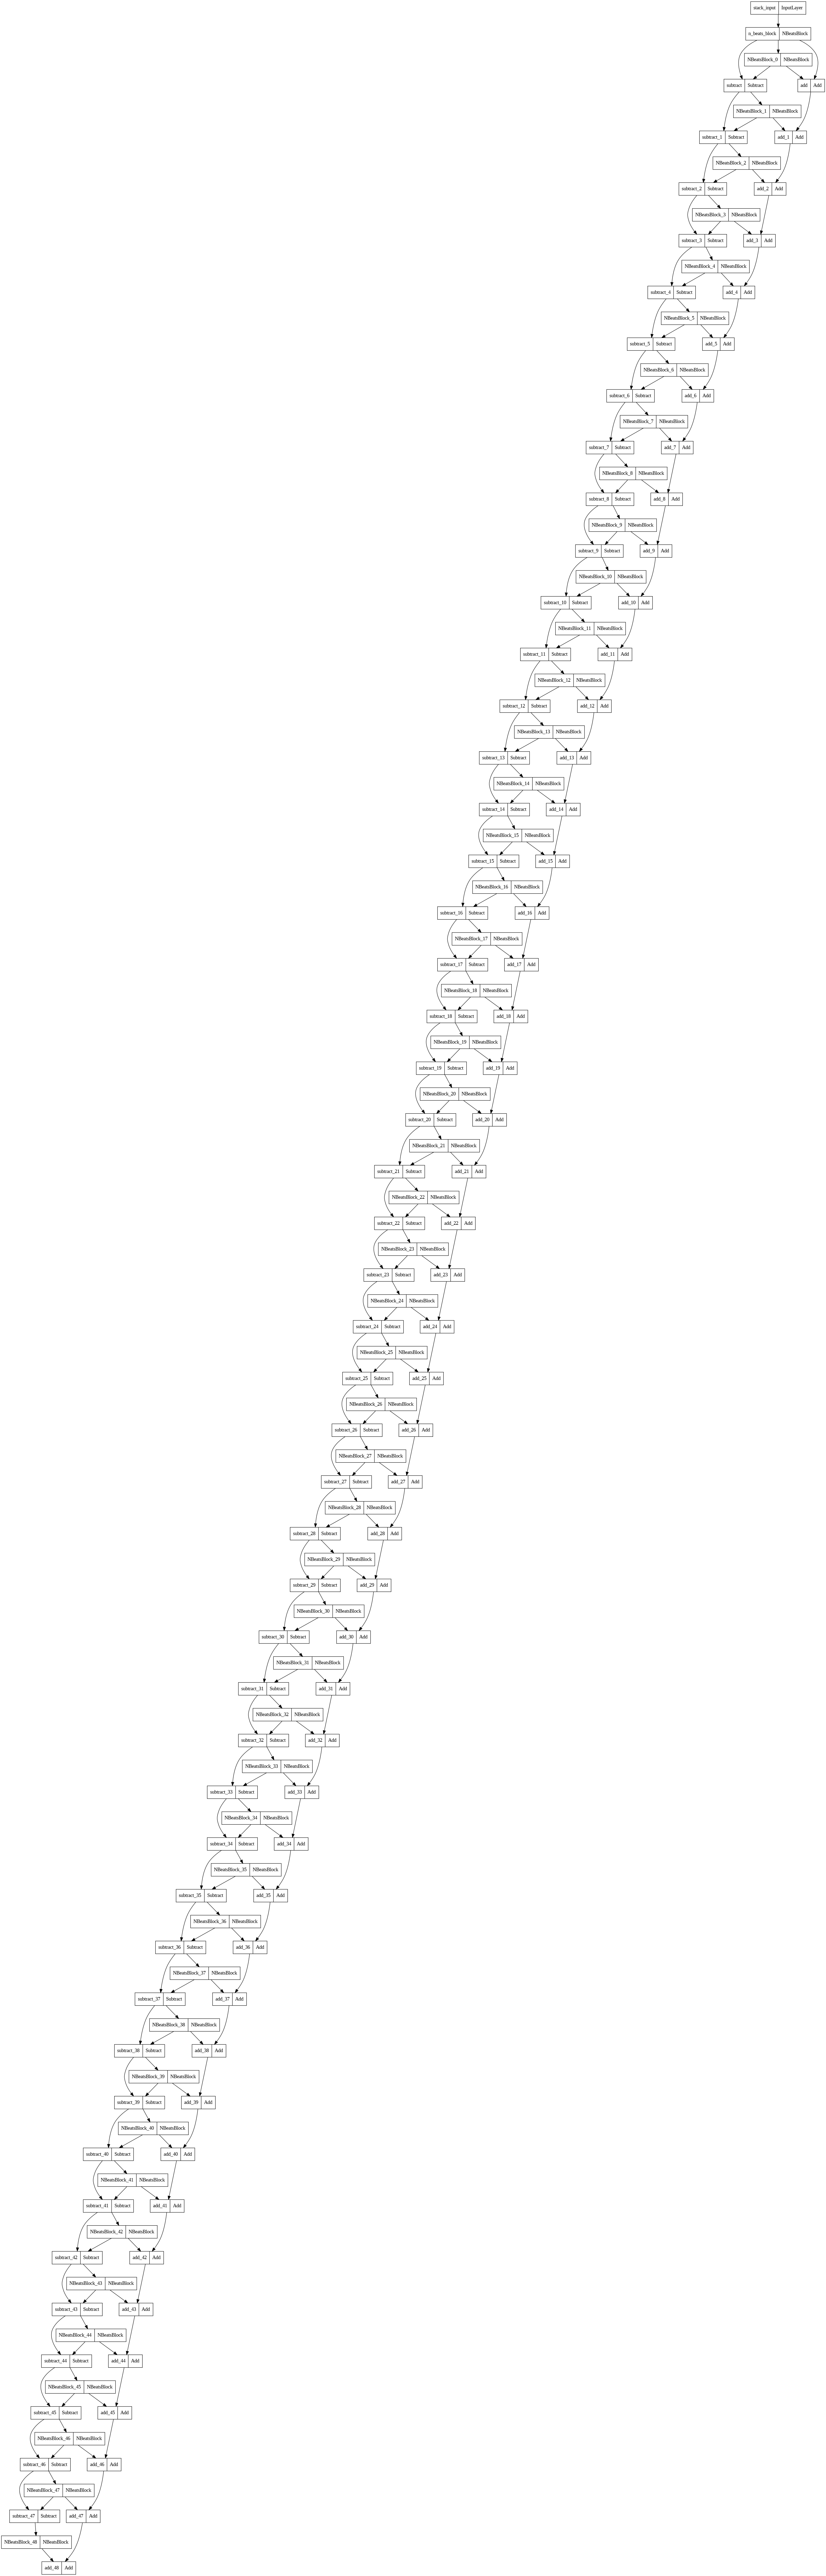

In [10]:
from tensorflow.keras.utils import plot_model

# create an example and show model summary
model = create_NBeats_model()

plot_model(model)

In [11]:
# print a summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 stack_input (InputLayer)    [(None, 15)]                 0         []                            
                                                                                                  
 n_beats_block (NBeatsBlock  ((None, 15),                 804368    ['stack_input[0][0]']         
 )                            (None, 1))                                                          
                                                                                                  
 NBeatsBlock_0 (NBeatsBlock  ((None, 15),                 804368    ['n_beats_block[0][0]']       
 )                            (None, 1))                                                          
                                                                                              

Now, let's prepare our data for our model and apply some feature engineering so that we can squeeze as much performance as possible during the training process.

# Preparing the Data (for our N-beats model)

In [12]:
# creating a new dataframe for our windowed data
closing_prices_nbeats = closing_prices.copy()


# create lagged closed prices
for i in range(WINDOW_SIZE):
  closing_prices_nbeats[f'Close_{i+1}'] = closing_prices_nbeats['Close'].shift(periods=i+1)

# create rolling statistics and rolling strength indexes for various periods
rolling_windows = [7, 14]

delta = closing_prices_nbeats['Close'].diff()

for window in rolling_windows:
  closing_prices_nbeats[f'Rolling_Mean_{window}d'] = closing_prices_nbeats['Close'].rolling(window=window).mean()
  closing_prices_nbeats[f'Rolling_Std_{window}d'] = closing_prices_nbeats['Close'].rolling(window=window).std()
  gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
  loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
  rs = gain / loss
  closing_prices_nbeats[f'RSI_{window}d'] = 100 - (100 / (1 + rs))

# create exponential moving averages for various periods
ema_spans = [7, 14]

for span in ema_spans:
  closing_prices_nbeats[f'EMA_{span}d'] = closing_prices_nbeats['Close'].ewm(span=span, adjust=False).mean()



# peeking at the result
closing_prices_nbeats.head(10)

,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Rolling_Mean_7d,Rolling_Std_7d,RSI_7d,Rolling_Mean_14d,Rolling_Std_14d,RSI_14d,EMA_7d,EMA_14d
Date,,,,,,,,,,,,,,,,
2008-01-31 00:00:00-05:00,4.097928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.097928,4.097928
2008-02-01 00:00:00-05:00,4.049186,4.097928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.085742,4.091429
2008-02-04 00:00:00-05:00,3.985608,4.049186,4.097928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.060709,4.077319
2008-02-05 00:00:00-05:00,3.916280,3.985608,4.049186,4.097928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.024601,4.055847
2008-02-06 00:00:00-05:00,3.693463,3.916280,3.985608,4.049186,4.097928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.941817,4.007529
2008-02-07 00:00:00-05:00,3.670453,3.693463,3.916280,3.985608,4.049186,4.097928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.873976,3.962586
2008-02-08 00:00:00-05:00,3.798817,3.670453,3.693463,3.916280,3.985608,4.049186,4.097928,NaN,3.887391,0.170049,23.093760,NaN,NaN,NaN,3.855186,3.940750
2008-02-11 00:00:00-05:00,3.919004,3.798817,3.670453,3.693463,3.916280,3.985608,4.049186,4.097928,3.861830,0.144684,36.766534,NaN,NaN,NaN,3.871141,3.937851
2008-02-12 00:00:00-05:00,3.780047,3.919004,3.798817,3.670453,3.693463,3.916280,3.985608,4.049186,3.823382,0.120304,32.437710,NaN,NaN,NaN,3.848367,3.916810


Now that we've windowed our data, let's remove all missing values, define our predictors `X` and our target `y`, and then split them into appropriate training and test sets.

In [13]:
X = closing_prices_nbeats.dropna().drop(['Close'], axis=1)
y = closing_prices_nbeats.dropna()['Close']

# define our split size
split_size = int(0.8*len(X))

# split into training and test
X_train, y_train = X.iloc[:split_size], y.iloc[:split_size]
X_test, y_test = X.iloc[split_size:], y.iloc[split_size:]


# check sizes
len(X_train), len(y_train), len(X_test), len(y_test)

(3212, 3212, 803, 803)

For max efficiency, let's convert our training and test sets into tensorflow datasets and use batching and optimal prefetching.

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1024).prefetch(tf.data.AUTOTUNE)

Now finally, let's compile our model with the Adam optimzer and with mean absolute error as our loss. During training, let's also use the `EarlyStopping` and `ReduceLROnPlataeu` callbacks to reduce the chances of overfitting.

In [15]:
# set random seed
tf.random.set_seed(42)

# create an N-beats model
model = create_NBeats_model()

# compile our model
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss='mae'
)

# train our model
model.fit(
    train_dataset,
    epochs=5000,
    validation_data=test_dataset,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=100, mode='min')
  ]
)

Epoch 1/5000
4/4 [==============================] - 83s 1s/step - loss: 132.4155 - val_loss: 136.4187 - lr: 0.0010
Epoch 2/5000
4/4 [==============================] - 1s 119ms/step - loss: 13.7364 - val_loss: 139.4864 - lr: 0.0010
Epoch 3/5000
4/4 [==============================] - 1s 171ms/step - loss: 20.0919 - val_loss: 34.6929 - lr: 0.0010
Epoch 4/5000
4/4 [==============================] - 0s 102ms/step - loss: 24.4392 - val_loss: 50.9572 - lr: 0.0010
Epoch 5/5000
4/4 [==============================] - 0s 101ms/step - loss: 20.4981 - val_loss: 104.3966 - lr: 0.0010
Epoch 6/5000
4/4 [==============================] - 1s 176ms/step - loss: 19.4457 - val_loss: 20.6996 - lr: 0.0010
Epoch 7/5000
4/4 [==============================] - 0s 103ms/step - loss: 9.4454 - val_loss: 32.1402 - lr: 0.0010
Epoch 8/5000
4/4 [==============================] - 0s 104ms/step - loss: 12.0322 - val_loss: 84.3444 - lr: 0.0010
Epoch 9/5000
4/4 [==============================] - 0s 107ms/step - loss: 18.37

Now that our model has finished training, let's evaluate our results and visualize our predictions.

# Making Predictions

In [63]:
# evaluating our results

# make some predictions
y_pred = tf.squeeze(model.predict(X_test), axis=1)

# get our results
nbeats_results = evaluate_predictions(y_test, y_pred)

# create a results dataframe
results_df = pd.DataFrame([
    nbeats_results,
    baseline_results
], index = ['N-beats', 'Naive-Forecast'])

# print our results
results_df

26/26 [==============================] - 0s 12ms/step


,MAE,RMSE,MASE
N-beats,1.839910,2.423467,0.927471
Naive-Forecast,1.979915,2.623477,0.999318


Across the board, we see that our N-beats model outperforms the naive forecast, showcasing the algorithm's usefulness at time-series forecasting. Finally, let's visualize our results with another time series plot.

In [91]:
from plotly.subplots import make_subplots

#create a dataframe for visualization purposes
viz_df = pd.DataFrame(y_test.copy().values, columns = ['True'], index=y_test.copy().index)
viz_df['N-beats'] = y_pred
viz_df['Naive'] = viz_df['True'].shift(1)
viz_df.dropna(inplace=True)

# create our nbeats figure
fig_1 = px.line(viz_df, y='True')

fig_1.add_trace(
    go.Scatter(
        x=viz_df.index,
        y=viz_df['N-beats'],
        mode='markers',
        marker=dict(size=4, color='Red', symbol='x'),
        name='N-beats'
    )
  )


fig_1.update_traces(
    line = dict(
        width=2,
        color= 'lightgreen'
    )
)

# create our naive forecast figure

fig_2 = px.line(viz_df, y='True')

fig_2.add_trace(
    go.Scatter(
        x=viz_df.index,
        y=viz_df['Naive'],
        mode='markers',
        marker=dict(size=4, color='darkorange', symbol='x'),
        name='Naive'
    )
  )

fig_2.update_traces(
    line = dict(
        width=2,
        color= 'lightgreen'
    )
  )


# combine figures into a single plot
combined_fig = make_subplots(rows=1, cols=2)

for trace in fig_1.data:
  combined_fig.add_trace(trace, row=1, col=1)

for trace in fig_2.data:
  combined_fig.add_trace(trace, row=1, col=2)

combined_fig.update_layout(
    template='plotly_dark',
    title = 'N-beats vs Naive Forecast',
    plot_bgcolor='black',
    xaxis_title='Date',
    yaxis_title='Closing Price',
    title_x=0.5,
    font=dict(
        family="Courier New, monospace",
        size=18,
        color= 'lightgreen'
    )
)

combined_fig.show()





# Results and Conclusions

In this project, we compared the naive forecast of AAPL stock prices to forecasts we obtained using an N-beats model, and found that the N-beats model outperforms the naive forecast on all the metrics we defined. This showcased the power of the N-beats algorithm at time-series forecasting. And in the future, it is worth investigating whether an ensemble of N-beats models might provide even more accurate results.